In [41]:
%matplotlib inline
import cPickle
import os
import random

from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import scipy
from scipy.signal import butter, lfilter, periodogram
from sklearn.ensemble import RandomForestClassifier

from sliding_window import sliding_window

import pandas as pd
from train_functions import *

In [327]:
df = pd.read_csv('data.txt',header=None,delimiter='sdafsdafdsaagdfgfdfds')
df = pd.read_csv('data_rest_walk_side',header=None,delimiter='sdafsdafdsaagdfgfdfds')
# df = pd.read_csv('data2.txt',header=None,delimiter='sdafsdafdsaagdfgfdfds')
# df = pd.read_csv('data_rest_walk_side2',header=None,delimiter='sdafsdafdsaagdfgfdfds')


_d = eval(df.iloc[0,0])


/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:1: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators; you can avoid this warning by specifying engine='python'.
  if __name__ == '__main__':
/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:2: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators; you can avoid this warning by specifying engine='python'.
  from ipykernel import kernelapp as app


In [328]:
def json2ts(di):
    time_label = [eval(di)[v] for v in ['timestamp','label']]
    xyz = [float(eval(di)['motion'][c]) for c in ['x','y','z']]
    return time_label + xyz

td = [json2ts(v) for v in _d]

In [329]:
# variables
win_size = 30 
fmin,fmax,sr = 0,8,win_size
over_lap = win_size/2
component_names = ['x','y','z']
cnames = ['time','label'] + component_names


df = pd.DataFrame(td,columns = cnames)
movement_names = set(df['label'])
print movement_names
# build features
y,mw = [],[]
for label in movement_names:
    _mw,_y = gen_td_examples(df,win_size,over_lap,component_names,label)
    print "{}: {} training examples".format(label, _mw[0].shape[0])
    mw.append(_mw)
    y.extend(_y)


mw = np.hstack(mw)
y = np.array(y)

tF = np.hstack([gen_td_features(ts) for ts in mw])
fF = np.hstack([gen_fd_features(ts,fmin,fmax,sr) for ts in mw])
X  = np.hstack([tF,fF])

cl = RandomForestClassifier(n_estimators=150)
cl.fit(X, y)

set([u'standing', u'walking', u'side 2 side'])
standing: 18 training examples
walking: 18 training examples
side 2 side: 18 training examples


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=150, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

(884, 5)


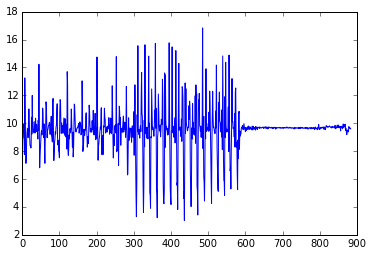

In [330]:
plt.plot(df['y'])
print df.shape

In [331]:
avg_score = []
avg_log_loss = []
for i in range(10):
    rand_ix  = np.random.choice(range(len(y)),len(y),replace = False)
    train_ix = rand_ix[0:27]
    test_ix  = rand_ix[27:]

    train_X  = X[train_ix]
    train_y  = y[train_ix]

    test_X   = X[test_ix]
    test_y   = y[test_ix]

    cl.fit(train_X, train_y)
    avg_score.append(cl.score(test_X,test_y))
    avg_log_loss.append(sklearn.metrics.log_loss(test_y,cl.predict_proba(test_X)))


In [335]:
set(df.label)

{u'side 2 side', u'standing', u'walking'}

In [336]:
l,l1,l2 = 'rest','rest1','rest2'
l,l1,l2 = 'rest','walking','side 2 side'
l,l1,l2 = 'standing','walking','side 2 side'

a=df[df['label']== l]['z']
b=df[df['label']== l1]['z']
c=df[df['label']== l2]['z']

In [338]:
from scipy.stats import ks_2samp
ks_2samp(a,c)

Ks_2sampResult(statistic=0.62279488066413013, pvalue=4.2792411505415096e-51)

In [265]:
from sklearn import cross_validation
clf = cl
shuffle = cross_validation.KFold(len(X), n_folds=2, shuffle=True, random_state=1)
scores = cross_validation.cross_val_score(clf, X, y, cv=shuffle)
print scores

[ 0.66666667  0.51851852]
